In [1]:
!nvidia-smi

Wed May 27 13:10:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Projects/Anomaly_Detection_Time_Series

/content/drive/My Drive/Projects/Anomaly_Detection_Time_Series


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
import tensorflow as tf
from nbeats_model import NBeatsNet

Using TensorFlow backend.


In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 512
    self.num_epochs = 100
    self.hidden_dim = 100
    self.theta_1 = 288
    self.theta_2 = 288
    self.nb_blocks_per_stack = 10
    
    self.save_folder = 'NBEATS'

In [0]:
args = Args()

In [0]:
os.makedirs('forecasts/', exist_ok=True)
os.makedirs('forecasts/' + args.save_folder, exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [14]:
X_train, y_train = make_windows(train_df)
X_val, y_val = make_windows(val_df)
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 9425.12it/s]


In [0]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [17]:
model = NBeatsNet(backcast_length = args.train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
model.compile_model(loss='mse', learning_rate = 1e-4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2016, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2016)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          201700      lambda_1[0][0]                   
                                                                 subtract_1[0][0]                 
                                                                 subtract_2[0][0]                 
                                                                 subtract_3[0][0]           

In [18]:
history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Train on 69697 samples, validate on 12097 samples
Epoch 1/100
69697/69697 [==============================] - 6s 92us/step - loss: 0.0656 - val_loss: 0.0194
Epoch 2/100
69697/69697 [==============================] - 5s 73us/step - loss: 0.0158 - val_loss: 0.0111
Epoch 3/100
69697/69697 [==============================] - 5s 73us/step - loss: 0.0105 - val_loss: 0.0085
Epoch 4/100
69697/69697 [==============================] - 5s 73us/step - loss: 0.0088 - val_loss: 0.0074
Epoch 5/100
69697/69697 [==============================] - 5s 74us/step - loss: 0.0079 - val_loss: 0.0067
Epoch 6/100
69697/69697 [==============================] - 5s 75us/step - loss: 0.0073 - val_loss: 0.0062
Epoch 7/100
69697/69697 [==============================] - 5s 75us/step - loss: 0.0068 - val_loss: 0.0060
Epoch 8/100
69697/69697 [==============================] - 5s 75us/step - loss: 0.0064 - val_loss: 0.0058
Epoch 9/100
69697/69697 [==============================] - 5s 76us/step - loss: 0.0061 - val_loss: 0.0

In [19]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.save_weights('forecasts/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
model.load_weights('forecasts/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

16

In [0]:
#24

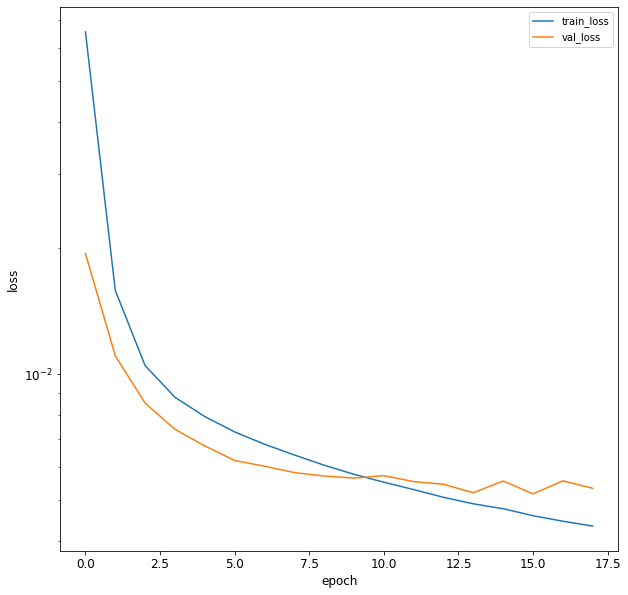

In [21]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.savefig('forecasts/' + args.save_folder + '/train_val_loss.png')
plt.show()

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred = y_pred.squeeze()
y_test = y_test.squeeze()

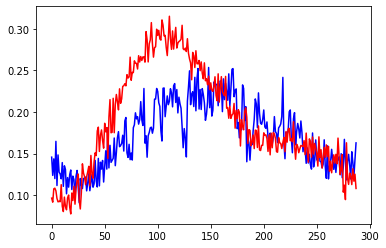

In [24]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred[0], color = 'red')
plt.savefig('forecasts/' + args.save_folder + '/test_1_pred.png')

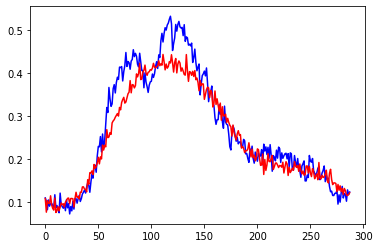

In [25]:
plt.plot(y_test[12*24*2], color = 'blue')
plt.plot(y_pred[12*24*2], color = 'red')
plt.savefig('forecasts/' + args.save_folder + '/test_2_pred.png')

In [26]:
forecasts = []
actuals = []
forecasts_n = []
actuals_n = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  forecasts_n += y_pred[12*24*i].tolist()
  actuals_n += y_test[12*24*i].tolist()

100%|██████████| 42/42 [00:00<00:00, 4716.36it/s]


In [0]:
df_pred = po.DataFrame()
df_pred['Predictions'] = forecasts
df_pred['Actual Values'] = actuals

In [0]:
df_pred.to_csv('forecasts/' + args.save_folder + '/full_results.csv', index = False)

In [0]:
df_pred_n = po.DataFrame()
df_pred_n['Predictions'] = forecasts_n
df_pred_n['Actual Values'] = actuals_n

In [0]:
df_pred_n.to_csv('forecasts/' + args.save_folder + '/full_results_normalized.csv', index = False)

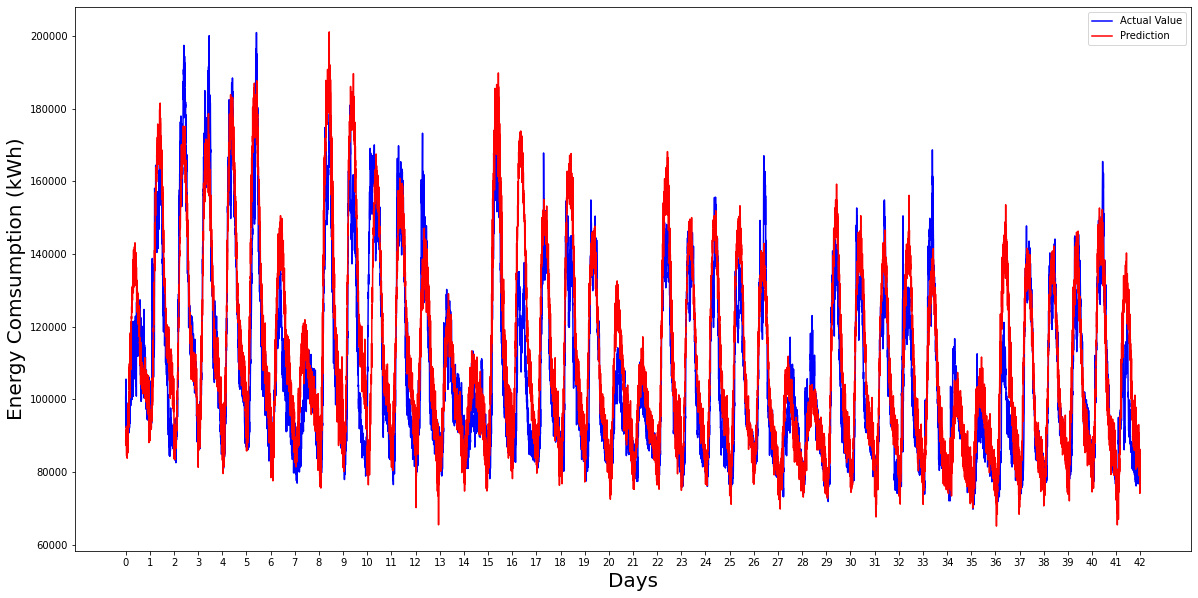

In [31]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/' + args.save_folder + '/forecast.png')

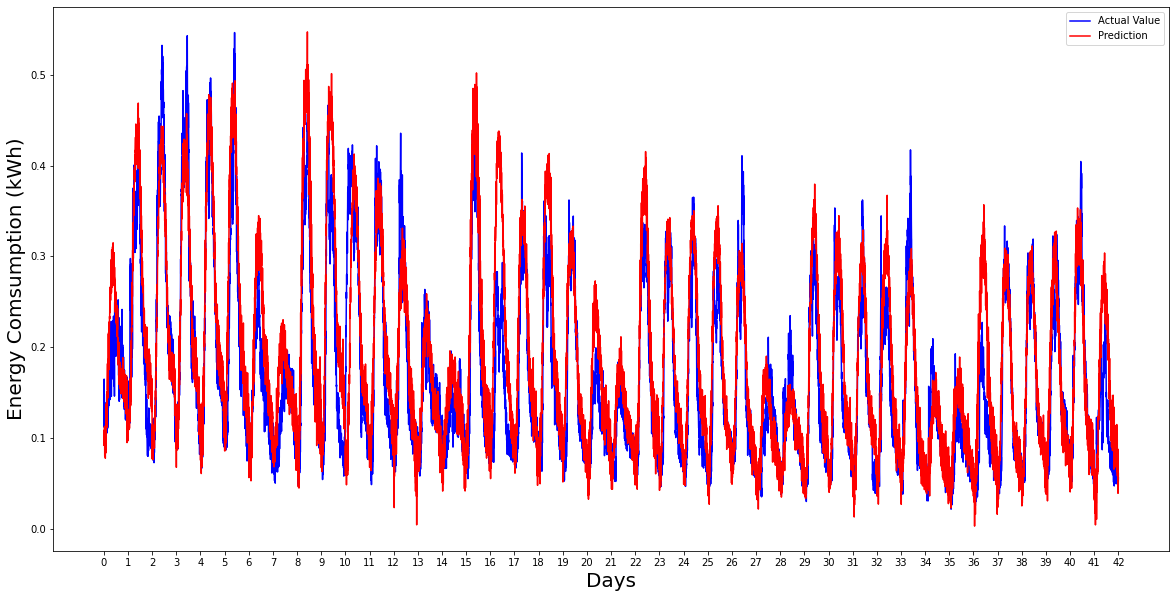

In [32]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals_n, color = 'blue')
plt.plot(forecasts_n, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/' + args.save_folder + '/forecast_normalized.png')

In [0]:
if not os.path.exists('forecasts/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2'])  
else:
  results = po.read_csv('forecasts/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [35]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,CNN_LSTM,0.048751,0.004090,0.583665,4.875098,0.063956
1,Dilated_CNN,0.049959,0.003910,0.601948,4.995887,0.062528
2,convLSTM,0.045311,0.003479,0.645889,4.531112,0.058987
3,weekend_forecast_Dilated_CNN,0.044546,0.002904,0.261048,4.454638,0.053893
4,weekend_forecast_CNN_LSTM,0.040486,0.002586,0.341039,4.048602,0.050856
5,weekend_forecast_conv_LSTM,0.038764,0.002416,0.385118,3.876431,0.049156
6,weekend_forecast_WaveNet,0.047001,0.003143,0.201000,4.700087,0.056060
7,WaveNet,0.038622,0.002722,0.722824,3.862250,0.052177
8,weekday_forecast_Dilated_CNN,0.057209,0.005262,0.633376,5.720929,0.072542
9,weekday_forecast_CNN_LSTM,0.039897,0.002807,0.804299,3.989721,0.052985


In [0]:
results.to_csv('forecasts/results.csv', index=False)